In [1]:
from __future__ import print_function
%matplotlib inline  

import numpy as np
import cPickle
import matplotlib.pyplot as plt
import caffe

In [2]:
def collage(data):
    images = [img for img in data.transpose(0, 2, 3, 1)]
    side = int(np.ceil(len(images)**0.5))
    for i in range(side**2 - len(images)):
        images.append(images[-1])
    collage = [np.concatenate(images[i::side], axis=0)
               for i in range(side)]
    collage = np.concatenate(collage, axis=1)
    #collage -= collage.min()
    #collage = collage / np.absolute(collage).max() * 256
    return collage
    

## Read data from CIFAR 10

Trn data shape: (80000, 3, 32, 32)
Tst data shape: (20000, 3, 32, 32)


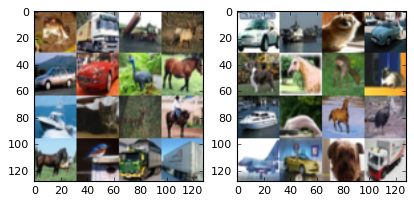

Trn labels shape:  (80000,)
Tst labels shape:  (20000,)
[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
[1 8 5 1 5 7 4 3 8 2 7 2 0 1 5 9 6 2 0 8]


In [3]:
trnData = []
trnLabels = []
tstData = []
tstLabels = []
for i in range(1,6):
    with open('../data_batch_{}'.format(i)) as f:
        data = cPickle.load(f)
    if i == 5:
        tstData = data['data']
        tstLabels = data['labels']
    else:
        trnData.append(data['data'])
        trnLabels.append(data['labels'])
trnData = np.concatenate(trnData).reshape(-1, 3, 32, 32)
trnData = np.concatenate([trnData[:,:,:,::-1], trnData[:,:,:,:]])
trnLabels = np.concatenate(trnLabels)
trnLabels = np.concatenate([trnLabels, trnLabels])
tstData = tstData.reshape(-1, 3, 32, 32)
tstData = np.concatenate([tstData[:,:,:,::-1], tstData[:,:,:,:]])
tstLabels = np.concatenate([tstLabels, tstLabels])

print('Trn data shape:', trnData.shape)
print('Tst data shape:', tstData.shape)
plt.subplot(1, 2, 1)
img = collage(trnData[:16])
plt.imshow(img)
plt.subplot(1, 2, 2)
img = collage(tstData[:16])
plt.imshow(img)
plt.show()

print('Trn labels shape: ', trnLabels.shape)
print('Tst labels shape: ', tstLabels.shape)
print(trnLabels[:20])
print(tstLabels[:20])

## Normalize data

In [4]:
trnData = trnData.astype(np.float32) / 255 - 0.5
tstData = tstData.astype(np.float32) / 255 - 0.5
'''def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix
    return ZCAMatrix
np.dot(ZCAMatrix, inputs)
'''


'def zca_whitening(inputs):\n    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix\n    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition\n    epsilon = 0.1                #Whitening constant, it prevents division by zero\n    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix\n    return ZCAMatrix\nnp.dot(ZCAMatrix, inputs)\n'

## Load solver

In [5]:
caffe.set_device(0)
caffe.set_mode_gpu()

solver = caffe.get_solver('net_solver.prototxt')

## Train network

In [36]:
batchSize = solver.net.blobs['data'].data.shape[0]
print('Blobs:', solver.net.blobs.keys())
for i in range(5000):
    pos = (i * batchSize) % trnData.shape[0]
    solver.net.blobs['data'].data[...] = trnData[pos:pos + batchSize,:, :, :]
    solver.net.blobs['labels'].data[...] = trnLabels[pos:pos + batchSize].reshape(-1,1,1,1)
    solver.step(1)
    if solver.iter % 50 == 0:
        print(solver.iter, solver.net.blobs['loss'].data, solver.net.blobs['acc'].data)


Blobs: ['data', 'labels', 'labels_labels_0_split_0', 'labels_labels_0_split_1', 'conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'conv4', 'pool5', 'fc6', 'fc7', 'fc8', 'fc8_fc8_0_split_0', 'fc8_fc8_0_split_1', 'acc', 'loss']
13050 0.599813222885 0.75
13100 0.44666826725 0.84375
13150 0.622502088547 0.859375
13200 0.775715529919 0.796875
13250 0.693348944187 0.75
13300 0.485565125942 0.84375
13350 0.54297542572 0.78125
13400 0.510131239891 0.828125
13450 0.651805400848 0.8125
13500 0.519112706184 0.84375
13550 0.83057898283 0.796875
13600 0.687725901604 0.765625
13650 0.783832073212 0.78125
13700 0.452220022678 0.859375
13750 0.718943953514 0.75
13800 0.683982610703 0.734375
13850 0.588938772678 0.828125
13900 0.763601601124 0.71875
13950 0.650324702263 0.765625
14000 0.576112926006 0.78125
14050 0.759684622288 0.703125
14100 0.455796122551 0.859375
14150 0.6389772892 0.734375
14200 0.634291231632 0.765625
14250 0.840450286865 0.8125
14300 0.608352482319 0.828125
14350 0.362111330032 0.8906

## Test network

In [37]:
testNet = solver.test_nets[0]
batchSize = 32
#change batch size
testNet.blobs['data'].reshape(batchSize, 3, 32, 32)
testNet.blobs['labels'].reshape(batchSize, 1, 1, 1)
testNet.reshape()
loss = 0
accuracy = 0
counter = 0
for i in range(0, tstData.shape[0]-batchSize, batchSize):
    testNet.blobs['data'].data[...] = tstData[i:i + batchSize,:, :, :]
    testNet.blobs['labels'].data[...] = tstLabels[i:i + batchSize].reshape(-1,1,1,1)
    testNet.forward()
    loss += testNet.blobs['loss'].data
    accuracy += testNet.blobs['acc'].data
    counter += 1
print('Test loss: ', loss / counter)
print('Test accuracy: ', accuracy / counter)

Test loss:  0.629014343382
Test accuracy:  0.794621394231


## Save and restore and deploy

In [38]:
# save snapshot to file with solver.iter in the name
solver.snapshot()

# save net
solver.net.save('myNet.model')

# load deploy net and compute some class probabilities
batchSize = 16
deployNet = caffe.Net('net_deploy.prototxt', 'myNet.model', caffe.TEST)
deployNet.blobs['data'].reshape(batchSize, 3, 32, 32)
deployNet.reshape()
deployNet.blobs['data'].data[...] = tstData[0:batchSize, :, :, :]
deployNet.forward()
print(tstLabels[0:batchSize])
for prob, label in zip(deployNet.blobs['out'].data, tstLabels):
    print('class: {} prob: {}'.format(label, prob[label]))


[1 8 5 1 5 7 4 3 8 2 7 2 0 1 5 9]
class: 1 prob: 1.0
class: 8 prob: 0.994896233082
class: 5 prob: 0.884689748287
class: 1 prob: 0.999888658524
class: 5 prob: 0.00277578271925
class: 7 prob: 0.947162508965
class: 4 prob: 0.107991918921
class: 3 prob: 0.78745675087
class: 8 prob: 0.999880671501
class: 2 prob: 0.812529504299
class: 7 prob: 0.850715339184
class: 2 prob: 0.380616515875
class: 0 prob: 0.999394893646
class: 1 prob: 0.989812076092
class: 5 prob: 0.857516527176
class: 9 prob: 0.0375619456172


# show filters

(32, 3, 5, 5) (30, 30, 3)


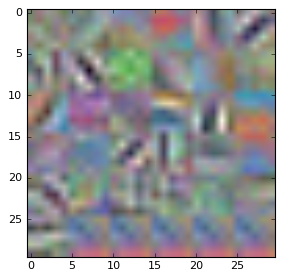

In [39]:
filters = deployNet.params['conv1'][0].data
filters = filters - filters.min()
filters = filters / filters.max()
img = collage(filters)
print(filters.shape, img.shape)
plt.imshow(img)
plt.show()

In [40]:
print('DONE')

DONE
